In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import scipy.linalg as la
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from timeit import timeit
%load_ext autoreload
%autoreload 2

Based on [https://ee227c.github.io/code/lecture5.html#projected-gd]

# Movie recommendation using low rank matrix completion

We are Netflix and have access to the ratings given by users to some movies they saw. Based on this data we want to predict the rating an user would give other movies.

### Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [52]:
from helpers import load_data, preprocess_data, split_data

path_dataset = "movielens100k.csv"
ratings = load_data(path_dataset, n =1000)

number of items: 1000, number of users: 1000


### Plot the number of ratings per movie and user

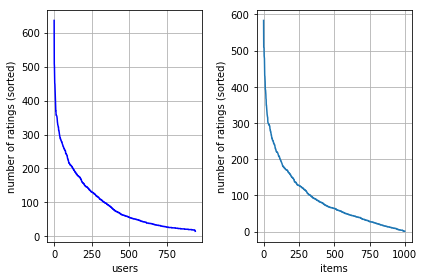

min # of items per user = 15, min # of users per item = 1.


In [65]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

the shape of original ratings. (# of row, # of col): (1000, 943)
the shape of valid ratings. (# of row, # of col): (1000, 943)
Total number of nonzero elements in origial data:92306
Total number of nonzero elements in train data:83858
Total number of nonzero elements in test data:8448


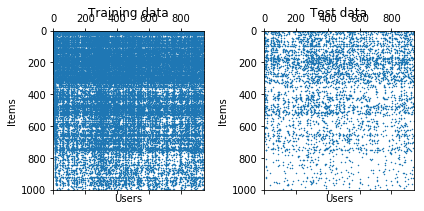

In [54]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=1, p_test=0.1)
plot_train_test_data(train, test)

## Learning low rank matrices

We want to minimize the squared error
$$
\min_{Y\in X\subseteq R^{n\times m}}\ \dfrac{1}{2}\sum_{(i,j)\in \Omega} (Z_{ij} - Y_{ij})^2
$$
when $\Omega\subseteq[n]\times[m]$ is the set of observed entries from a given matrix $Z$.

Since without more assumptions this is a hopeless problem, we assume that the *true* matrix $Y$ is low rank. As a proxy for low rank, we assume that the trace norm of $Y$ is bounded.

In this case, our optimization domain is the unit ball of the trace norm (or nuclear norm), which is known to be the convex hull of the rank-1 matrices 
$$
X := \mathop{conv}(\mathcal{A}) \ \text{ with }\ \mathcal{A} := \Big\{ u v^\top \ \Big|\ \substack{u\in R^n,\;||{u}||_2=1\\ v\in R^m,\;||{v}||_2=1} \Big\} \ .
$$

In [5]:
def cost_se(Y,Z):
    """Compute the objective function on an input matrix Y for the data matrix Z
    Assume all (and only) non-zero values of Z are observed"""
    cost = 0
    observed_rows,observed_columns = np.nonzero(Z)
    errors = Z[observed_rows,observed_columns] - Y[observed_rows,observed_columns]
    cost = 0.5 * errors.dot(errors.T)
    return cost
    

## Implementing Baselines 

### Use the global mean to do the prediction

In [6]:
def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    observed_rows,observed_columns = np.nonzero(train)
    global_mean = np.mean(train[observed_rows,observed_columns])
    Y = np.ones(train.shape)*global_mean
    test_error = cost_se(Y,test)
    print("The test error of baseline using global mean: {v}.".format(v=test_error))

baseline_global_mean(train, test)

The test error of baseline using global mean: 0.030711852855926286.


### Use the user means as the prediction

In [7]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    num_items, num_users = train.shape
    Y = np.ones(train.shape)
    for user in range(num_users):
        column = train[:,user]
        observed_rows = np.nonzero(column)
        user_mean = np.mean(column[observed_rows])
        Y[:, user] = np.ones(len(column))*user_mean

    test_error = cost_se(Y,test)
    print("The test error of baseline using user mean: {v}.".format(v=test_error))

baseline_user_mean(train, test)

The test error of baseline using user mean: 0.027102673221818207.


### Use the item means as the prediction

In [8]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    num_items, num_users = train.shape
    Y = np.zeros(train.shape)
    for item in range(num_items):
        row = train[item]
        observed_columns = np.nonzero(row)
        item_mean = np.mean(row[observed_columns])
        Y[item] = np.ones(len(row))*item_mean
    test_error = cost_se(Y,test)
    print("The test error of baseline using item mean: {v}.".format(v=test_error))
    
baseline_item_mean(train, test)

The test error of baseline using item mean: 0.025933677282916335.


## Learn matrix using projected gradient descent

In [9]:
def compute_gradient(Y,Z):
    """Compute the gradient of the objective.
    Assume that all non-zero values in Z are observed and so are part of \Omega"""
    gradient = np.zeros(Y.shape)
    observed_rows,observed_columns = np.nonzero(Z)
    errors = Y-Z
    gradient[observed_rows,observed_columns] = errors[observed_rows,observed_columns]
    return gradient

In [10]:
def project_onto_simplex(s):
    """Given a vector s, find its projection onto the unit simplex"""        
    if np.sum(s) <=1 and np.alltrue(s >= 0):
        return s
    # Code taken from https://gist.github.com/daien/1272551
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, len(u)+1) > (cssv - 1))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = (cssv[rho] - 1) / (rho + 1.0)
    # compute the projection by thresholding v using theta
    return np.maximum(s-theta, 0)

def project_onto_tracenormball(S):
    """Compute the projection of the matrix S onto the set X (the unit ball of the trace norm)
    Hint: use the simplex projection function you wrote above"""
    
    svds
    U, s, V = svds(S, k = min(S.shape) - 1)
    s = project_onto_simplex(s)
    return U.dot(np.diag(s).dot(V))

#### Cost of a projecting onto a trace norm ball
How does the cost of the projection scale with respect to increasing dimension?

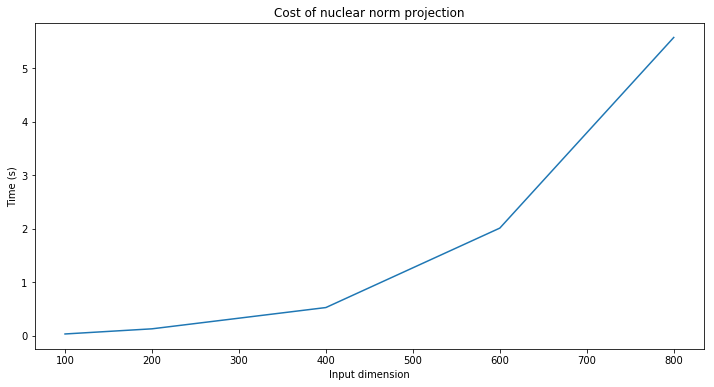

In [11]:
ts = []
ns = [100, 200, 400, 600, 800]
for n in ns:
    f = lambda: project_onto_tracenormball(np.random.normal(0,1,(n, n)))
    ts.append(timeit(f, number=1))

plt.figure(figsize=(12,6))
plt.xlabel('Input dimension')
plt.ylabel('Time (s)')
plt.title('Cost of nuclear norm projection')
plt.plot(ns, ts)

#### Running projected gradient descent

In [59]:
from optimizers import gradient_descent

# start from random matrix of nuclear norm 1
Y0 = np.random.normal(0,1, train.shape)
Y0 = project_onto_tracenormball(Y0)
# define the train and test error
test_objective = lambda Y: cost_se(Y, test)
train_objective = lambda Y: cost_se(Y, train)
# run the gradient descent algorithm
gradient = lambda Y: compute_gradient(Y, train)
Ys, ts = gradient_descent(Y0, [0.2]*10, gradient, project_onto_tracenormball)

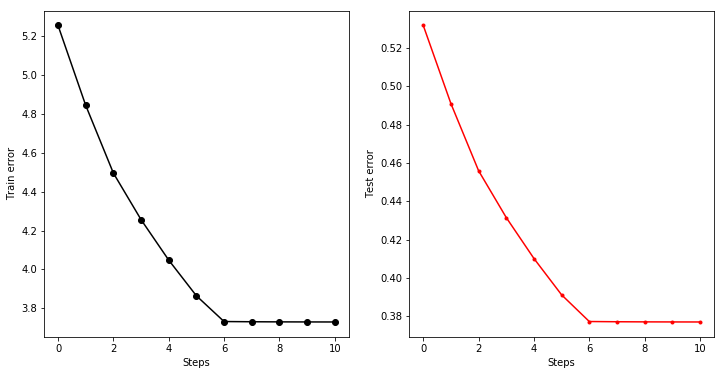

In [60]:
"""Plot the test and train errors vs. number of iterations"""
plt.figure(figsize=(12,6))
plt.title('Projected gradient descent error')
plt.subplot(1, 2, 1)
plt.ylabel('Train error')
plt.xlabel('Steps')
plt.plot(np.arange(len(Ys)), [train_objective(Y) for Y in Ys], 'ko-')

plt.subplot(1, 2, 2)
plt.ylabel('Test error')
plt.xlabel('Steps')
plt.plot(np.arange(len(Ys)), [test_objective(Y) for Y in Ys], 'r.-')

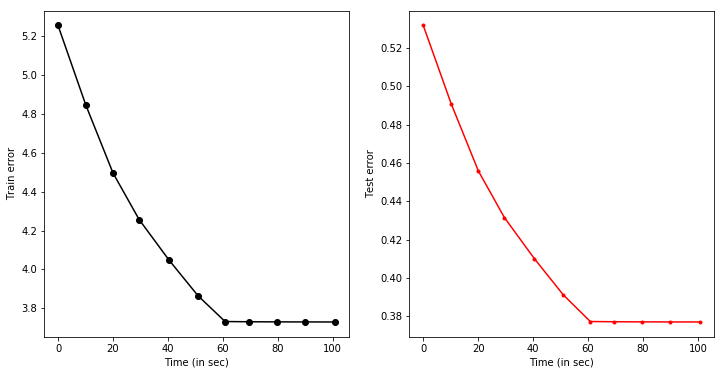

In [61]:
"""Plot the test and train errors vs. time"""
plt.figure(figsize=(12,6))
plt.title('Projected gradient descent error')
plt.subplot(1, 2, 1)
plt.ylabel('Train error')
plt.xlabel('Time (in sec)')
plt.plot(ts, [train_objective(Y) for Y in Ys], 'ko-')

plt.subplot(1, 2, 2)
plt.ylabel('Test error')
plt.xlabel('Time (in sec)')
plt.plot(ts, [test_objective(Y) for Y in Ys], 'r.-')

## Learn matrix using Frank-Wolfe

In [15]:
def LMO(S):
    """Compute the linear maximization oracle (LMO) over the unit ball of the trace norm (nuclear norm) for an input S"""
    u,s,v = svds(S, k = 1)
    return u.dot(v)


In [24]:
def gss(f, a, b, tol=1e-5):
    """Golden section search.
        Source: https://en.wikipedia.org/wiki/Golden-section_search
    Find the minimum of f on [a,b]
    Parameters:
    -----------
        f: a strictly unimodal function on [a,b]
        a: lower interval boundary
        b: uper interval boundary
    Returns:
    --------
        Point in the interval [a, b]
    """
    gr = 1.6180339887498949
    c = b - (b - a) / gr
    d = a + (b - a) / gr 
    while abs(c - d) > tol:
        if f(c) < f(d):
            b = d
        else:
            a = c
        # we recompute both c and d here to avoid loss of precision 
        # which may lead to incorrect results or infinite loop
        c = b - (b - a) / gr
        d = a + (b - a) / gr
    return (b + a)/2

In [33]:
def line_search(Y,V,Z):
    cost_func = lambda gamma: cost_se(Y + gamma*(V-Y),Z)
    opt_gamma = gss(cost_func,0,1)
    return Y + opt_gamma*(V-Y)
    

In [46]:
def cond_grad_update(Y, Z, t):
    """Compute the Frank-Wolfe update.
    Here t is the iteration number, Y is the current point and Z is the observed matrix"""
    gradient = compute_gradient(Y,Z)
    V = LMO(-gradient)
    gamma = 2./(t+2.)
    update = Y + gamma*(V - Y)
    """Uncomment the below line if you want to perform line search to find a better gamma"""
    #update = line_search(Y,V,Z)
    return update

### Comparing cost of Projection and Linear Minimization

In [47]:
ts1 = []
ts2 = []
ns = [100, 200, 400, 600, 800]
for n in ns:
    f = lambda: project_onto_tracenormball(sp.random(n,n))
    ts1.append(timeit(f, number=1))
    f = lambda: LMO(np.random.normal(0,1,(n, n)))
    ts2.append(timeit(f, number=1))

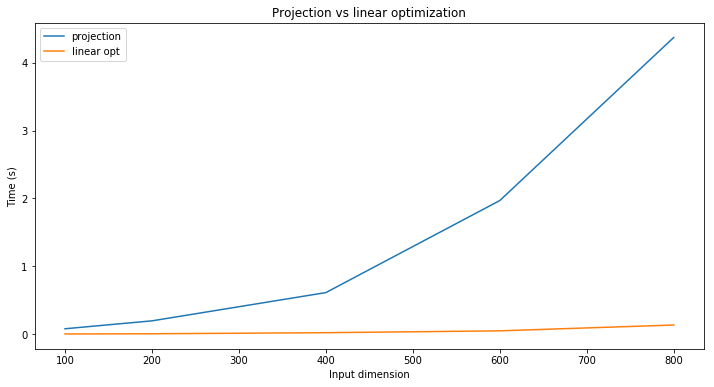

In [18]:
plt.figure(figsize=(12,6))
plt.xlabel('Input dimension')
plt.ylabel('Time (s)')
plt.title('Projection vs linear optimization')
plt.plot(ns, ts1, label='projection')
plt.plot(ns, ts2, label='linear opt')
plt.legend()

#### Running Frank-Wolfe

In [62]:
from optimizers import frank_wolfe

# start from random matrix of nuclear norm 1
Y0 = np.random.normal(0,1, train.shape)
Y0 = project_onto_tracenormball(Y0)
# define the train and test error
test_objective = lambda Y: cost_se(Y, test)
train_objective = lambda Y: cost_se(Y, train)
# run the Frank-Wolfe algorithm
update_oracle = lambda Y,k: cond_grad_update(Y, train, k)
Ys, ts = frank_wolfe(Y0, update_oracle, num_steps = 10)

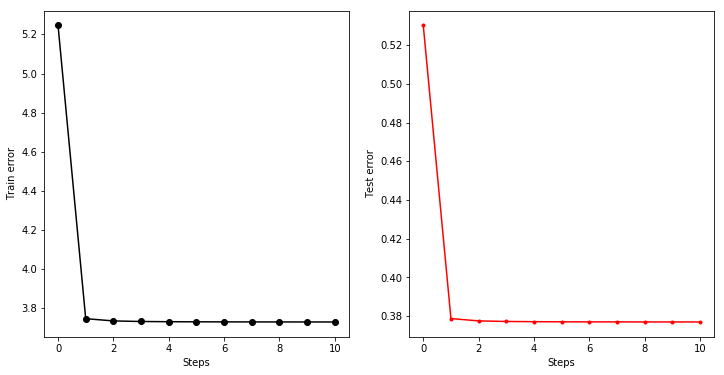

In [63]:
"""Plot the test and train errors vs. number of iterations"""
plt.figure(figsize=(12,6))
plt.title('Frank-Wolfe error vs. Number of iterations')
plt.subplot(1, 2, 1)
plt.ylabel('Train error')
plt.xlabel('Steps')
plt.plot(np.arange(len(Ys)), [train_objective(Y) for Y in Ys], 'ko-')

plt.subplot(1, 2, 2)
plt.ylabel('Test error')
plt.xlabel('Steps')
plt.plot(np.arange(len(Ys)), [test_objective(Y) for Y in Ys], 'r.-')

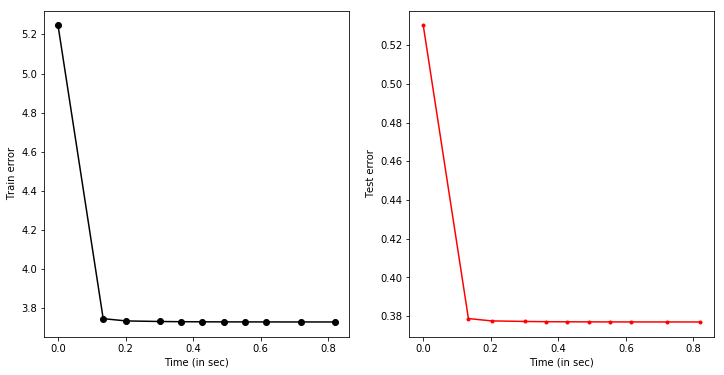

In [64]:
"""Plot the test and train errors vs. time"""
plt.figure(figsize=(12,6))
plt.title('Frank-Wolfe error vs. Time')
plt.subplot(1,2, 1)
plt.ylabel('Train error')
plt.xlabel('Time (in sec)')
plt.plot(ts, [train_objective(Y) for Y in Ys], 'ko-')

plt.subplot(1, 2, 2)
plt.ylabel('Test error')
plt.xlabel('Time (in sec)')
plt.plot(ts, [test_objective(Y) for Y in Ys], 'r.-')

FW is 300 times faster! You can play around with different updates (the line search code is also provided) and see what happens. You can also try load bigger/different datasets (increase n in load_data function) and see how FW scales.

## A more practical method

In practice, to learn a low rank matrix, neither Frank-Wolfe nor Projected Gradient Descent are used. Instead, we formulate a **non-convex** problem which is then solved by SGD. In particular if we want to learn a rank $k$ matrix, $X$ is replaced by two matrices $UV^\top$ where $U \in R^{n\times k}$ and $V \in R^{m \times k}$. This means that we never have to store the full matrix $X$ which would take $O(mn)$ space but instead only $O(mk + nk)$ space. Futher, the matrices $U$ and $V$ can be interpreted as *embeddings*. There have been recent theoretical results which prove that this algorithm in fact recovers the correct answer under some assumptions!

Refer to this exercise from Machine Learning course (https://github.com/epfml/ML_course/blob/master/labs/ex10/solution/ex10.ipynb) for more details.